## Enviroment Setup

In [1]:
! apt-get install default-jre
! java -version
! pip install h2o

Reading package lists... Done
Building dependency tree       
Reading state information... Done
default-jre is already the newest version (2:1.11-68ubuntu1~18.04.1).
default-jre set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.
openjdk version "11.0.9.1" 2020-11-04
OpenJDK Runtime Environment (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04)
OpenJDK 64-Bit Server VM (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
     |████████████████████████████████| 164.6MB 76kB/s 
  Created wheel for h2o: filename=h2o-3.32.0.2-py2.py3-none-any.whl size=164620456 sha256=78c7b375bdeab97ee57335fc50dd9bd6f2ed2ba963580cab73ee0836a1856541
  Stored in directory: /root/.cache/pip/wheels/42/bd/ea/218fd15724eddf6fa7fc8fab802b6fa592e623d87199679721
Successfully built h2o


In [2]:
import h2o
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pylab import rcParams
rcParams['figure.figsize'] = 20, 12

file_path = "/content/drive/My Drive/Colab Notebooks/IPRAD/kddcup.data.corrected.csv"

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Initialise H2O

In [3]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.9.1" 2020-11-04; OpenJDK Runtime Environment (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmps6nhnwbx
  JVM stdout: /tmp/tmps6nhnwbx/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmps6nhnwbx/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.2
H2O_cluster_version_age:,27 days
H2O_cluster_name:,H2O_from_python_unknownUser_tnui91
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.180 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


## Data Preparation

In [4]:
columns = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent",
        "hot", "num_failed_logins", "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root", 
        "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
        "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
        "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", 
        "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate",
        "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]

df = pd.read_csv(file_path, sep=",", names=columns, index_col=None)

df.shape

(4898431, 42)

Next, filter out the entire data frame to only include data entries that involve an HTTP attack, and drop the service column

In [5]:
df = df[df["service"] == "http"]
df = df.drop("service", axis=1)
columns.remove("service")

In [6]:
df.shape

(623091, 41)

The number of rows has been drastically reduced, and the column count went down by one because we removed the service column since we don't actually need it anymore.

Let us check all the possible labels and the number of counts for each label, just to get a feel of the data distribution. Run the following cell.

In [7]:
df["label"].value_counts()

normal.       619046
back.           2203
neptune.        1801
portsweep.        16
ipsweep.          13
satan.             7
phf.               4
nmap.              1
Name: label, dtype: int64

The vast majority of the dataset is comprised of normal data entries, with around 0.649% of data entries for all HTTP attacks comprising actual intrusion attacks.

Additionally, some of the columns have categorical data values, meaning the model will have trouble training on them. To bypass this issue, we use a build-in feature of scikit-learn calla a label encoder (we used this in previous LUs too)

In [8]:
df.head(5)

,duration,protocol_type,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,SF,215,45076,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,SF,162,4528,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,SF,236,1228,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,SF,233,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal.


The first half of the data frame "novelties" consists of anomalies, while the latter half consists of normal data entries. We can now move on to encode all the categorical values in the data frames.

In [9]:
from sklearn.preprocessing import LabelEncoder

for col in df.columns:
    if df[col].dtype == "object":
        encoded = LabelEncoder()
        encoded.fit(df[col])
        df[col] = encoded.transform(df[col])

In [10]:
df.head(5)

,duration,protocol_type,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,0,9,215,45076,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,4
1,0,0,9,162,4528,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,4
2,0,0,9,236,1228,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,4
3,0,0,9,233,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,4
4,0,0,9,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,4


In [11]:
df['label'].values[df['label'].values > 4] = 8
df['label'].values[df['label'].values <4] = 8
df['label'].values[df['label'].values == 8] = 1
df['label'].values[df['label'].values == 4] = 0
df["label"].value_counts()

0    619046
1      4045
Name: label, dtype: int64

Next, we will shuffle the values in df and create our training , testing and validation datasets.

With <pre> df = df.iloc[np.dandom.permutation(len(df))] </pre>

we are randomly shuffling all the entries in the datset to avoid the problem of adbormal entries pooling in any one region of the dataset. <p>

With <pre>df2 = df[:500000]</pre>

we are assigning the first 500,000 entries of df to a variable df2. <p>

In the next line, <pre>labels = df2["label"]</pre>
we assign the label column to the variable labels, Next, we assgin the rest of the dataframe to a variable named df_validate to create the validation dataset with <pre>df_validate = df[500000:]</pre>

To spit the data into the training set and testing set, we can use scikit-learn function train_test_split().

In [12]:
from sklearn.model_selection import train_test_split

for f in range(0, 3):
    df = df.iloc[np.random.permutation(len(df))]
    
df2 = df[:500000]
labels = df2["label"]
df_validate = df[500000:]
x_train, x_test, y_train, y_test = train_test_split(df2, labels, test_size = 0.2, random_state = 42)

x_val, y_val = df_validate, df_validate["label"]

In [13]:
print("Shapes:\nx_train:%s\ny_train:%s\n" % (x_train.shape, y_train.shape))
print("x_test:%s\ny_test:%s\n" % (x_test.shape, y_test.shape))
print("x_val:%s\ny_val:%s\n" % (x_val.shape, y_val.shape))

Shapes:
x_train:(400000, 41)
y_train:(400000,)

x_test:(100000, 41)
y_test:(100000,)

x_val:(123091, 41)
y_val:(123091,)



## Create and Train Model
https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/if.html

https://www.h2o.ai/blog/anomaly-detection-with-isolation-forests-using-h2o/



In [14]:
seed = 12345
ntrees = 100
isoforest = h2o.estimators.H2OIsolationForestEstimator( ntrees=ntrees, max_depth= 30, seed=seed )
isoforest.train(x=h2o.H2OFrame(x_train).col_names[:], training_frame=h2o.H2OFrame(x_train))

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/h2o/estimators/estimator_base.py:200: RuntimeWarning: Dropping bad and constant columns: [is_host_login, protocol_type, wrong_fragment, su_attempted, num_file_creations, land, urgent, is_guest_login, num_outbound_cmds, num_failed_logins]
  warnings.warn(mesg["message"], RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/h2o/estimators/estimator_base.py:200: RuntimeWarning: Stopping tolerance is ignored for _stopping_rounds=0.
  warnings.warn(mesg["message"], RuntimeWarning)


isolationforest Model Build progress: |███████████████████████████████████| 100%


## Evaluate Model

In [15]:
predictions = isoforest.predict(h2o.H2OFrame(x_train))

Parse progress: |█████████████████████████████████████████████████████████| 100%
isolationforest prediction progress: |████████████████████████████████████| 100%


In [16]:
predictions

predict,mean_length
0.690841,8.82
0.241748,18.48
0.144119,20.58
0.0390516,22.84
0.318921,16.82
0.519293,12.51
0.0939098,21.66
0.771734,7.08
0.514179,12.62
0.722455,8.14


Since our dataset has about 0.065% of anomaly, we will set the quantile to 0.9935

In [17]:
quantile = 0.9935
quantile_frame = predictions.quantile([quantile])
quantile_frame

Probs,predictQuantiles,mean_lengthQuantiles
0.9935,0.841469,23.11


In [18]:
y_df = y_train.to_frame()
temp_y = h2o.H2OFrame(y_df)
type(temp_y)

Parse progress: |█████████████████████████████████████████████████████████| 100%


h2o.frame.H2OFrame

In [19]:
threshold = quantile_frame[0, "predictQuantiles"]
predictions["predicted_class"] = predictions["predict"] > threshold
predictions["label"] = h2o.H2OFrame(y_df)
predictions

Parse progress: |█████████████████████████████████████████████████████████| 100%


predict,mean_length,predicted_class,label
0.690841,8.82,0,0
0.241748,18.48,0,0
0.144119,20.58,0,0
0.0390516,22.84,0,0
0.318921,16.82,0,0
0.519293,12.51,0,0
0.0939098,21.66,0,0
0.771734,7.08,0,0
0.514179,12.62,0,0
0.722455,8.14,0,0


In [20]:
x_train["label"].value_counts()

0    397456
1      2544
Name: label, dtype: int64

In [21]:
y_df["label"].value_counts()

0    397456
1      2544
Name: label, dtype: int64

In [22]:
threshold

0.8414690841469085

In [23]:
temp_df = predictions.as_data_frame() 
temp_df["predicted_class"].value_counts()

0    397420
1      2580
Name: predicted_class, dtype: int64

In [24]:
temp_df[temp_df["predicted_class"] == 1]

,predict,mean_length,predicted_class,label
51,0.849837,5.40,1,0
57,0.991167,2.36,1,1
100,0.853556,5.32,1,0
290,0.880521,4.74,1,0
459,0.990237,2.38,1,1
...,...,...,...,...
399454,0.986983,2.45,1,1
399481,0.865644,5.06,1,0
399618,0.848907,5.42,1,0
399750,0.853556,5.32,1,0


In [25]:
temp_df[temp_df["label"] == 1]

,predict,mean_length,predicted_class,label
57,0.991167,2.36,1,1
459,0.990237,2.38,1,1
509,0.993956,2.30,1,1
746,0.936309,3.54,1,1
995,0.828452,5.86,0,1
...,...,...,...,...
399030,0.797304,6.53,0,1
399107,0.799628,6.48,0,1
399454,0.986983,2.45,1,1
399534,0.802882,6.41,0,1


Because the isolation forest is an unsupervised method, it makes sense to have a look at the classification metrics that are not dependent on the prediction threshold and give an estimate of the quality of scoring. Two such metrics are **Area Under the Receiver Operating Characteristic Curve (AUC)** and **Area under the Precision-Recall Curve (AUCPR)**.

AUC is a metric evaluating how well a binary classification model distinguishes true positives from false positives. The perfect AUC score is 1; the baseline score of a random guessing is 0.5.

AUCPR is a metric evaluating the precision recall trade-off of a binary classification using different thresholds of the continuous prediction score. The perfect AUCPR score is 1; the baseline score is the relative count of the positive class.

For highly imbalanced data, AUCPR is recommended over AUC as the AUCPR is more sensitive to True positives, False positives and False negatives, while not caring about True negatives, which in large quantity usually overshadow the effect of other metrics.

In [26]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
import numpy as np


def get_auc(labels, scores):
    fpr, tpr, thresholds = roc_curve(labels, scores)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score


def get_aucpr(labels, scores):
    precision, recall, th = precision_recall_curve(labels, scores)
    aucpr_score = np.trapz(recall, precision)
    return precision, recall, aucpr_score


def plot_metric(ax, x, y, x_label, y_label, plot_label, style="-"):
    ax.plot(x, y, style, label=plot_label)
    ax.legend()
    
    ax.set_ylabel(x_label)
    ax.set_xlabel(y_label)


def prediction_summary(labels, predicted_score, predicted_class, info, plot_baseline=True, axes=None):
    if axes is None:
        axes = [plt.subplot(1, 2, 1), plt.subplot(1, 2, 2)]

    fpr, tpr, auc_score = get_auc(labels, predicted_score)
    plot_metric(axes[0], fpr, tpr, "False positive rate",
                "True positive rate", "{} AUC = {:.4f}".format(info, auc_score))
    if plot_baseline:
        plot_metric(axes[0], [0, 1], [0, 1], "False positive rate",
                "True positive rate", "baseline AUC = 0.5", "r--")

    precision, recall, aucpr_score = get_aucpr(labels, predicted_score)
    plot_metric(axes[1], recall, precision, "Recall",
                "Precision", "{} AUCPR = {:.4f}".format(info, aucpr_score))
    if plot_baseline:
        thr = sum(labels)/len(labels)
        plot_metric(axes[1], [0, 1], [thr, thr], "Recall",
                "Precision", "baseline AUCPR = {:.4f}".format(thr), "r--")

    plt.show()
    return axes


def figure():
    fig_size = 4.5
    f = plt.figure()
    f.set_figheight(fig_size)
    f.set_figwidth(fig_size*2)

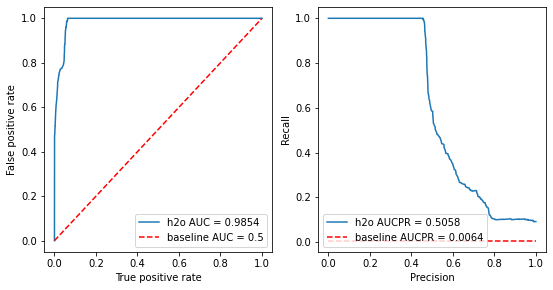

In [27]:
h2o_predictions = predictions.as_data_frame()

figure()
axes = prediction_summary(
    h2o_predictions["label"], h2o_predictions["predict"], h2o_predictions["predicted_class"], "h2o")

In [28]:
from sklearn.metrics import confusion_matrix
confusion_matrix(h2o_predictions["label"], h2o_predictions["predicted_class"])

array([[396186,   1270],
       [  1234,   1310]])